In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodels
import imodelsx.process_results
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
# from custom_classifier import TabPFNClassifier
# from custom_regressor import TabPFNRegressor
from tabpfn import TabPFNClassifier, TabPFNRegressor

from sklearn.datasets import make_classification, make_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Functional analysis

0it [00:00, ?it/s]

11it [00:01,  8.44it/s]


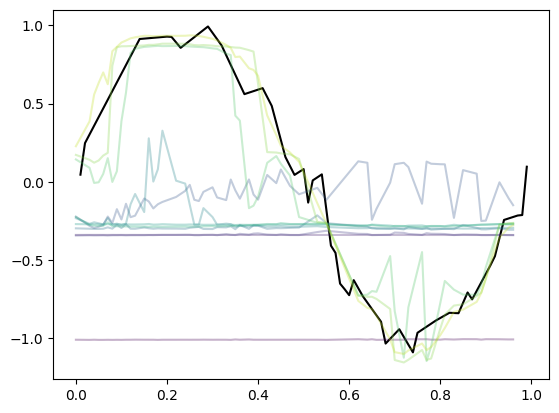

In [45]:
# data
n = 1000
d = 1
test_frac = 0.6

# regression
X = np.arange(0, 1, 0.01).reshape(-1, 1)
# y = np.sin(2 * np.pi * X) + 0.1 * np.random.randn(*X.shape)
y = np.sin(2 * np.pi * X) + 0.1 * np.random.randn(*X.shape)
y = y.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=42)
# sort by X
X_train, y_train = zip(*sorted(zip(X_train, y_train)))
X_test, y_test = zip(*sorted(zip(X_test, y_test)))
plt.plot(X_train, y_train, color='black')

# get 12 viridis colors
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 12)]

for i, n_enc_layers in tqdm(enumerate(np.arange(1, 12))):
    regressor = TabPFNRegressor(
        device='cuda', n_estimators=1, n_enc_layers=n_enc_layers)
    regressor.fit(X_train, y_train)
    y_test_tabpfn = regressor.predict(X_test)

    plt.plot(X_test, y_test_tabpfn, label=str(
        n_enc_layers), color=colors[i], alpha=0.3)
plt.show()
# print('r2 test', r2_score(y_test, y_test_tabpfn))

### Activations analysis

In [ ]:
# data
n = 2000
d = 20
test_frac = 0.2

# DGP
n_classes = 2
n_informative = 10

# regression
X, y = make_regression(
    n_samples=n, n_features=d, n_informative=n_informative, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=42)
regressor = TabPFNRegressor(device='cuda', n_estimators=12, n_enc_layers=5)
regressor.fit(X_train, y_train)
y_test_tabpfn = regressor.predict(X_test)
print('r2 test', r2_score(y_test, y_test_tabpfn))

# classification
# X, y = make_classification(
#     n_samples=n, n_features=d, n_informative=n_informative, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=test_frac, random_state=42)
# classifier = TabPFNClassifier(device='cuda', n_estimators=1)
# classifier.fit(X_train, y_train)
# y_test_tabpfn = classifier.predict(X_test)
# print('acc test', accuracy_score(y_test, y_test_tabpfn))

r2 test -0.024403099428347508


In [12]:
# model = classifier
model = regressor
m = model.model_
activations = {}


def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook


# Register hooks on specific layers (example: Transformer blocks)
for idx, block in enumerate(m.transformer_encoder.layers):
    block.self_attn_between_features.register_forward_hook(
        get_activation(f'enc_attn_f_{idx}'))
for idx, block in enumerate(m.transformer_encoder.layers):
    block.self_attn_between_items.register_forward_hook(
        get_activation(f'enc_attn_i_{idx}'))
for idx, block in enumerate(m.transformer_encoder.layers):
    block.register_forward_hook(get_activation(f'enc_{idx}'))
for idx, block in enumerate(m.decoder_dict.standard):
    block.register_forward_hook(get_activation(f'dec_{idx}'))

# Fit model (for inference)
# preds = model.predict_proba(X_test)
preds = model.predict(X_test, output_type='mode')
print('initial inputs.shape', X_test.shape)
print('final preds.shape', preds.shape)

# Display extracted activations

print('enc sizes are batch_size, num_samples (train + test), n_heads, d_output?')
# note: half the heads are training heads, whereas the other half are inference heads which do not attend to each other
print(
    'dec sizes are (num_samples [test], 1, 10 classes [actual values are the first n_classes, rest are dropped])')
# note: regression basically does 5000-class classification over quantiles then averages them
# (classification is easier to study)
for layer, activation in activations.items():
    print(f"{layer}: {activation.shape}")

[transformer LayerStack] x torch.Size([1, 2000, 12, 192])
[transformer LayerStack] x torch.Size([1, 2000, 12, 192])
[transformer LayerStack] x torch.Size([1, 2000, 12, 192])
[transformer] encoder_out torch.Size([1, 2000, 12, 192])
initial inputs.shape (400, 20)
final preds.shape (400,)
enc sizes are batch_size, num_samples (train + test), n_heads, d_output?
dec sizes are (num_samples [test], 1, 10 classes [actual values are the first n_classes, rest are dropped])
enc_attn_f_0: torch.Size([1, 2000, 12, 192])
enc_attn_i_0: torch.Size([1, 12, 1600, 192])
enc_0: torch.Size([1, 2000, 12, 192])
enc_attn_f_1: torch.Size([1, 2000, 12, 192])
enc_attn_i_1: torch.Size([1, 12, 1600, 192])
enc_1: torch.Size([1, 2000, 12, 192])
enc_attn_f_2: torch.Size([1, 2000, 12, 192])
enc_attn_i_2: torch.Size([1, 12, 1600, 192])
enc_2: torch.Size([1, 2000, 12, 192])
dec_0: torch.Size([400, 1, 768])
dec_1: torch.Size([400, 1, 768])
dec_2: torch.Size([400, 1, 5000])


In [ ]:
d = vars(m.transformer_encoder.layers[0].self_attn_between_features)
# only show elements with scalar values
for k, v in d.items():
    if np.isscalar(v):
        print(k, v)

### increasing tree depth experiment

In [ ]:
# data
n = 2000
d = 20
test_frac = 0.2

# DGP
n_classes = 2
n_informative = 10

# generate synthetic data from decision trees of increasing depths and test tabpfn acc
r = defaultdict(list)
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
r['depth'] = depths
for depth in tqdm(depths):
    X, y = make_classification(
        n_samples=n, n_features=d, n_informative=n_informative, n_classes=n_classes, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_frac, random_state=42)
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)
    y_train_tree = tree.predict(X_train)
    y_test_tree = tree.predict(X_test)

    classifier = TabPFNClassifier(device='cuda')
    classifier.fit(X_train, y_train_tree)
    y_test_tabpfn = classifier.predict(X_test)
    acc = accuracy_score(y_test_tree, y_test_tabpfn)
    r['acc'].append(acc)
    print(acc)

r = pd.DataFrame(r)
sns.lineplot(data=r, x='depth', y='acc')
plt.show()